In [1]:
%cd /content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project

/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project


In [2]:
import os
import glob
import random
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# directory = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/train'
# all_images = os.listdir(os.path.join(directory, 'PNEUMONIA'))

# random_images = random.sample(all_images, 1341)
# output_directory = os.path.join(directory, 'Pneumonia')

# os.makedirs(output_directory, exist_ok=True)

# for image in random_images:
#     src_path = os.path.join(os.path.join(directory, 'PNEUMONIA'), image)
#     dst_path = os.path.join(output_directory, image)
#     shutil.copy(src_path, dst_path)

In [10]:
# len(glob.glob(os.path.join(directory, 'Pneumonia/*.jpeg')))

1341

In [32]:
train_data_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/train'
val_data_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/val'


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [33]:
class_to_label = train_dataset.class_to_idx
label_to_class = {value: key for key, value in class_to_label.items()}
label_to_class

{0: 'NORMAL', 1: 'Pneumonia'}

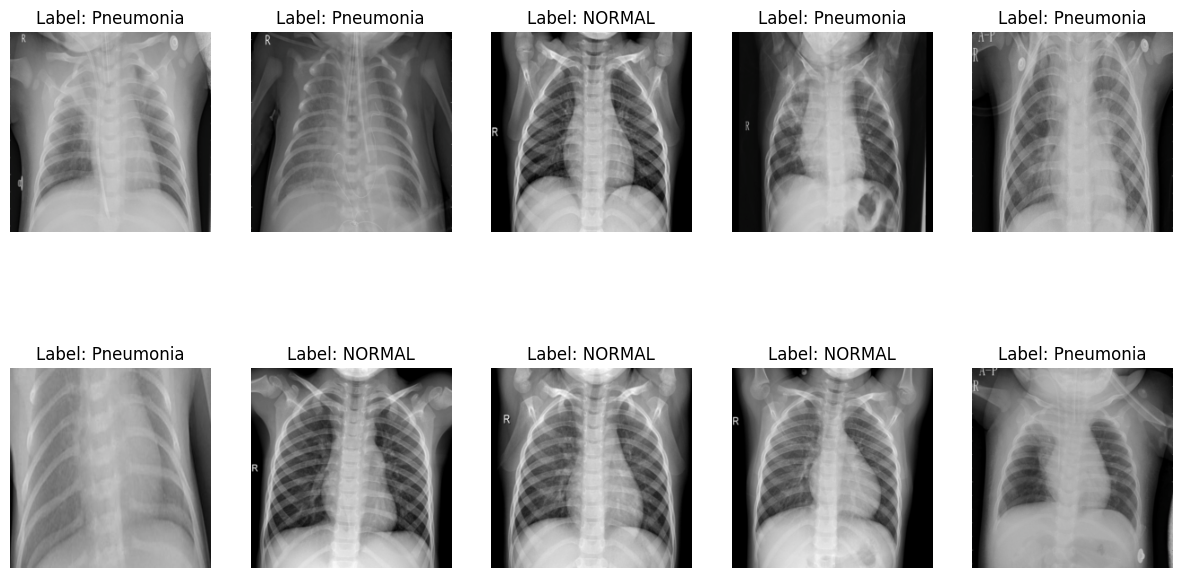

In [35]:
imgs, labels = next(iter(train_loader))


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i in range(imgs[:10].shape[0]):
    ax = axes[i//5, i%5]

    unnormalized_img = np.transpose(imgs[i].numpy(), (1, 2, 0))
    unnormalized_img = np.clip((unnormalized_img * std) + mean, 0, 1)

    ax.imshow(unnormalized_img)
    ax.set_title(f'Label: {label_to_class[labels[i].item()]}')
    ax.axis('off')


plt.show()

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

for param in model.parameters():
    param.requires_grad = False

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
total_iterations = 100
iter_count = 0

while iter_count < total_iterations:
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # forward pass
        output = model(imgs)
        loss = criterion(labels, output)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_count += 1

        # validate after every 20 iterations
        if iter_count % 20 == 0:
            model.eval()
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)

                    output = model(imgs)
                    loss = criterion(labels, output)

